In [1]:
import gc
import os
import sys
import warnings
from glob import glob

import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
from segmentation_models_pytorch.decoders.unet.decoder import DecoderBlock
from timm.models.resnet import resnet10t, resnet34d
from torch.cuda import amp
from tqdm import tqdm
from einops import rearrange


In [2]:
sys.path.append('/kaggle/working/notebook/experiment/stacked_unet')
from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.loss import *

### Config

In [3]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    dataset_path = "/kaggle/working/dataset_train/"
    train_dataset_path = "/kaggle/working/dataset_train/nonflatten/24-39/"
    dataset_range = train_dataset_path.split("/")[-2]

    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============

    z_start = int(train_dataset_path.rstrip("/").split("/")[-1].split("-")[0])
    z_end = int(train_dataset_path.rstrip("/").split("/")[-1].split("-")[1])
    in_chans = z_end-z_start+1
    
    crop_depth = 6
    random_shift = 2
    layer_shift = [0, 2, 4, 6, 8]
    
    # ============== training cfg =============
    size = 256
    tile_size = 256
    stride = tile_size //2

    train_batch_size = 64  # 32
    valid_batch_size = train_batch_size

    epochs = 30  # 15

    lr = 1e-4
    loss = "bce_dice_loss"


    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                        mask_fill_value=0, p=0.5),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)


### Load data

In [4]:
def preprocess(image, fragment_i, split_i):
    image=np.clip(image,a_min=10000,a_max=50000)
    return image



len(train_images) = 11194
train_images[0].shape = (256, 256, 16)
train_labels[0].shape = (256, 256, 1)
train_masks[0].shape = (256, 256, 1)

len(valid_images) = 3087
valid_images[0].shape = (256, 256, 16)
valid_labels[0].shape = (256, 256, 1)



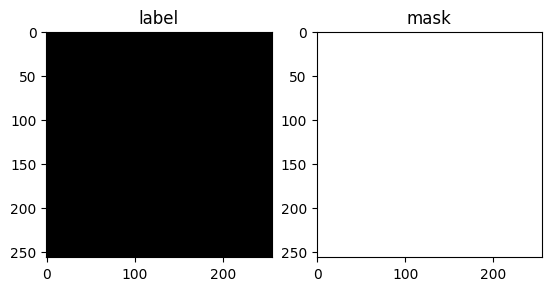

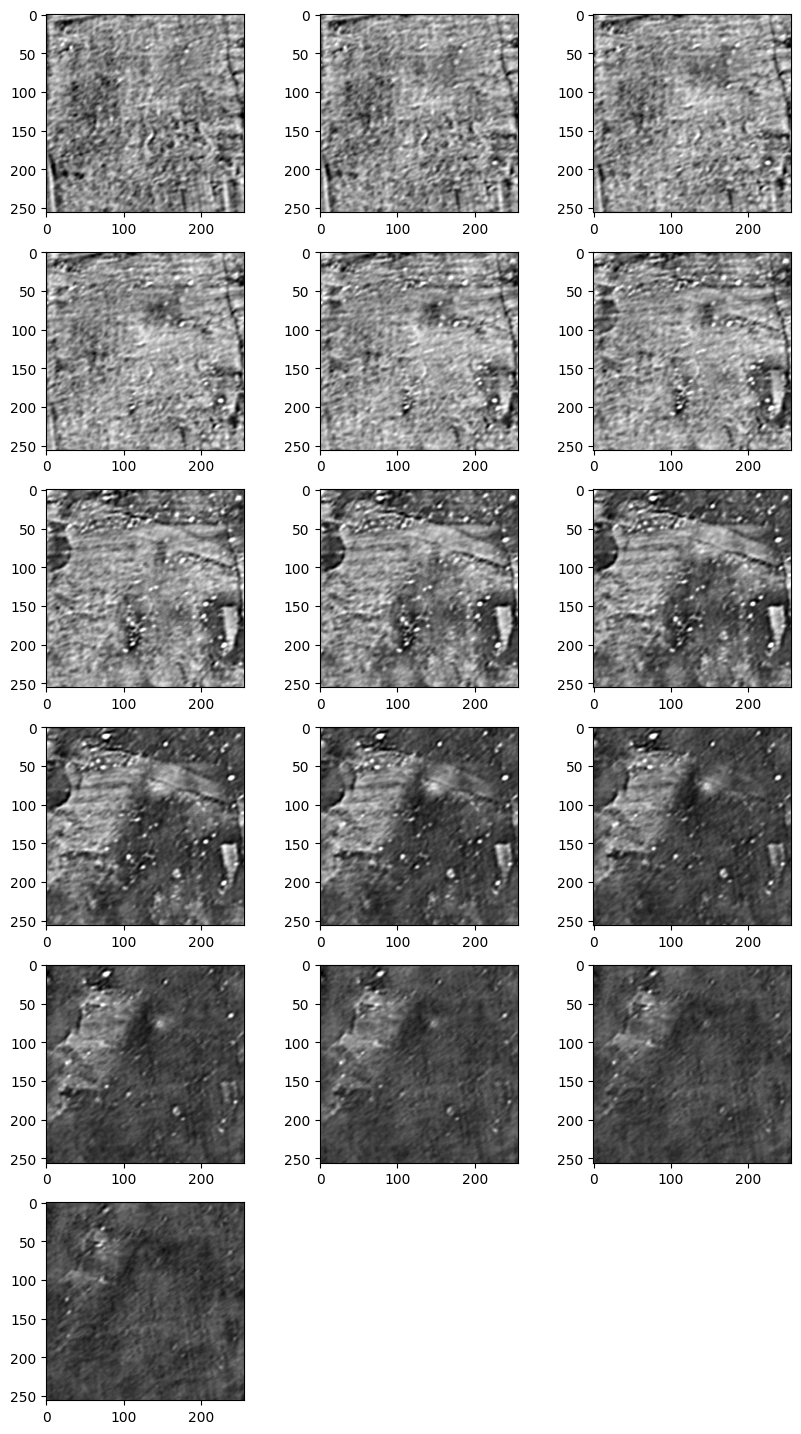

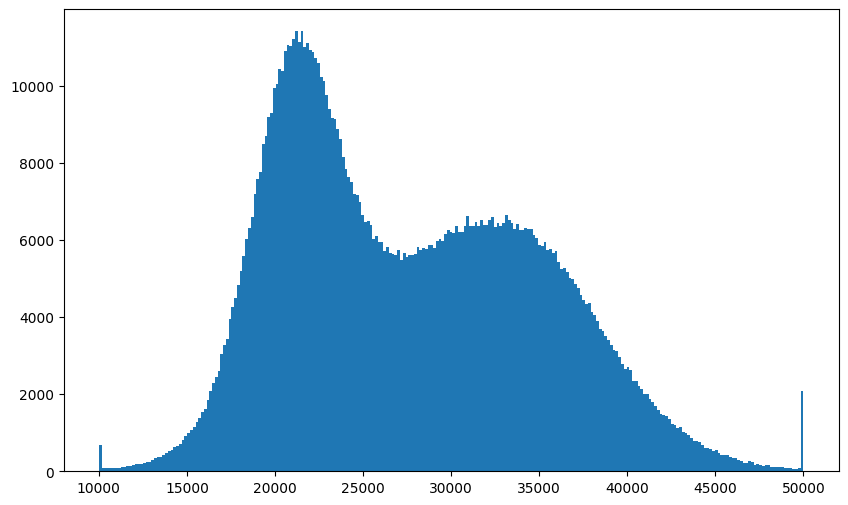

In [5]:
# confirmation

valid_fragment_i = 1
valid_split_i = 0

train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess)

print(f"""
{len(train_images) = }
{train_images[0].shape = }
{train_labels[0].shape = }
{train_masks[0].shape = }

{len(valid_images) = }
{valid_images[0].shape = }
{valid_labels[0].shape = }
""")

id = random.randint(0, len(train_labels))
visualize_train_images(id, train_images, train_labels, train_masks)


### Model

In [6]:
class SmpUnetDecoder(nn.Module):
    def __init__(self,
                 in_channel,
                 skip_channel,
                 out_channel,
                 ):
        super().__init__()
        self.center = nn.Identity()

        i_channel = [in_channel,] + out_channel[:-1]
        s_channel = skip_channel
        o_channel = out_channel
        block = [
            DecoderBlock(i, s, o, use_batchnorm=True, attention_type=None)
            for i, s, o in zip(i_channel, s_channel, o_channel)
        ]
        self.block = nn.ModuleList(block)

    def forward(self, feature, skip):
        d = self.center(feature)
        decode = []
        for i, block in enumerate(self.block):
            s = skip[i]
            d = block(d, s)
            decode.append(d)

        last = d
        return last, decode


class Net(nn.Module):
    def __init__(self,):
        super().__init__()
        self.output_type = ['inference', 'loss']

        conv_dim = 64
        encoder1_dim = [conv_dim, 64, 128, 256, 512, ]
        decoder1_dim = [256, 128, 64, 64,]

        self.encoder1 = resnet34d(pretrained=True, in_chans=CFG.crop_depth)

        self.decoder1 = SmpUnetDecoder(
            in_channel=encoder1_dim[-1],
            skip_channel=encoder1_dim[:-1][::-1],
            out_channel=decoder1_dim,
        )
        # -- pool attention weight
        self.weight1 = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(dim, dim, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            ) for dim in encoder1_dim
        ])
        self.logit1 = nn.Conv2d(decoder1_dim[-1], 1, kernel_size=1)

        # --------------------------------
        #
        encoder2_dim = [64, 128, 256, 512]
        decoder2_dim = [128, 64, 32, ]
        self.encoder2 = resnet10t(pretrained=True, in_chans=decoder1_dim[-1])

        self.decoder2 = SmpUnetDecoder(
            in_channel=encoder2_dim[-1],
            skip_channel=encoder2_dim[:-1][::-1],
            out_channel=decoder2_dim,
        )
        self.logit2 = nn.Conv2d(decoder2_dim[-1], 1, kernel_size=1)

    def forward(self, batch):
        v = batch
        B, C, H, W = v.shape
        random_shift = random.randint(0, CFG.random_shift)
        vv = [
            v[:, i+random_shift:i+random_shift+CFG.crop_depth] for i in CFG.layer_shift
        ]
        K = len(vv)
        x = torch.cat(vv, 0)
        # x = v

        # ----------------------
        encoder = []
        e = self.encoder1
        x = e.conv1(x)
        x = e.bn1(x)
        x = e.act1(x)
        encoder.append(x)
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
        x = e.layer1(x)
        encoder.append(x)
        x = e.layer2(x)
        encoder.append(x)
        x = e.layer3(x)
        encoder.append(x)
        x = e.layer4(x)
        encoder.append(x)
        # print('encoder', [f.shape for f in encoder])

        for i in range(len(encoder)):
            e = encoder[i]
            e = F.avg_pool2d(e, kernel_size=4, stride=4)
            f = self.weight1[i](e)
            _, c, h, w = e.shape
            f = rearrange(f, '(K B) c h w -> B K c h w', K=K, B=B, h=h, w=w)  #
            e = rearrange(e, '(K B) c h w -> B K c h w', K=K, B=B, h=h, w=w)  #
            w = F.softmax(f, 1)
            e = (w * e).sum(1)
            encoder[i] = e

        feature = encoder[-1]
        skip = encoder[:-1][::-1]
        last, decoder = self.decoder1(feature, skip)
        logit1 = self.logit1(last)

        # ----------------------
        x = last  # .detach()
        # x = F.avg_pool2d(x,kernel_size=2,stride=2)
        encoder = []
        e = self.encoder2
        x = e.layer1(x)
        encoder.append(x)
        x = e.layer2(x)
        encoder.append(x)
        x = e.layer3(x)
        encoder.append(x)
        x = e.layer4(x)
        encoder.append(x)

        feature = encoder[-1]
        skip = encoder[:-1][::-1]
        last, decoder = self.decoder2(feature, skip)
        logit2 = self.logit2(last)
        logit1 = F.interpolate(logit1, size=(H, W), mode='bilinear', align_corners=False, antialias=True)
        logit2 = F.interpolate(logit2, size=(H, W), mode='bilinear', align_corners=False, antialias=True)

        return logit1, logit2


### Training

In [7]:
for fold_i, fold in enumerate(glob(f"{CFG.train_dataset_path}/*")):
    fold = os.path.basename(fold).split(".")[0]
    valid_fragment_i = int(fold.split("_")[0])
    valid_split_i = int(fold.split("_")[1])
    print(f"fold: {fold_i}")

    train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess, "inklabels")

    dataloader_train, dataloader_valid = generate_dataloader(train_images, train_labels,  valid_images, valid_labels, valid_xyxys, CFG)

    n_train = len(dataloader_train)
    n_valid = len(dataloader_valid)

    gt_mask = generate_valid_label(valid_fragment_i, valid_split_i, CFG, "inklabels")
    gt_shape = gt_mask.shape


    num_gpus = torch.cuda.device_count()
    device_ids = list(range(num_gpus))

    model = Net()
    model = nn.DataParallel(model, device_ids=device_ids)
    model = model.cuda()

    scaler = amp.GradScaler()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
    scheduler = get_scheduler(CFG, optimizer)

    fbeta = 0

    for epoch in range(CFG.epochs):
        model.train()
        cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
        pbar_train = enumerate(dataloader_train)
        pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
        mloss_train, mloss_val = 0.0, 0.0

        for i, (fragments, masks) in pbar_train:
            fragments, masks = fragments.cuda(), masks.cuda()
            optimizer.zero_grad()
            with amp.autocast():  # type: ignore
                logit1, logit2 = model(fragments)
                loss1 = criterion(logit1, masks)
                loss2 = criterion(logit2, masks)
                loss = loss1+loss2
                scaler.scale(loss).backward()# type: ignore
                scaler.step(optimizer)
                scaler.update()
                mloss_train += loss.detach().item()

            gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
            pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.epochs}", gpu_mem, cur_lr,
                                                                  f"Loss: {mloss_train / (i + 1):.4f}"))

        scheduler.step()
        model.eval()
        pbar_val = enumerate(dataloader_valid)
        pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
        final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')  # type: ignore
        final_pred_count = torch.zeros(gt_shape)

        for i, (fragments, masks, xys) in pbar_val:
            fragments, masks = fragments.cuda(), masks.cuda()
            with torch.no_grad():
                logit1, logit2 = model(fragments)
                loss1 = criterion(logit1, masks)
                loss2 = criterion(logit2, masks)
                loss = loss1+loss2
                mloss_val += loss.detach().item()
                pred_masks = torch.sigmoid(logit2)

            for j, xy in enumerate(xys):
                final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] += pred_masks[j, 0]
                final_pred_count[xy[1]:xy[3], xy[0]:xy[2]] += np.ones((CFG.size, CFG.size))

            pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
        final_pred_mask = final_pred_mask.cpu()
        final_pred_mask /= final_pred_count

        fbeta_ = fbeta_score(final_pred_mask, gt_mask, 0.5)
        print(f"FBeta : {fbeta_:.4f}\tSAVED MODEL\n" if fbeta_ > fbeta else f"FBeta : {fbeta_:.4f}\n")
        if fbeta_ > fbeta:
            fbeta = fbeta_
            model_path = f'./{CFG.exp_name}/{CFG.exp_name}_fold{fold_i}.pth'
            torch.save({'model': model.module.state_dict(),
                        'preds': final_pred_mask.numpy()},
                       model_path)

    del model
    gc.collect()
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！' https://notify-api.line.me/api/notify


fold: 0


Epoch 0/30  Mem : 21.8GB  LR : 1.00E-04  Loss: 0.9695: 100%|██████████| 174/174 
Val Loss: 0.7957: 100%|██████████| 49/49 [00:10<00:00,  4.67it/s]               


FBeta : 0.3916	SAVED MODEL



Epoch 1/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.6043: 100%|██████████| 174/174 
Val Loss: 0.5191: 100%|██████████| 49/49 [00:10<00:00,  4.76it/s]               


FBeta : 0.3890



Epoch 2/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4877: 100%|██████████| 174/174 
Val Loss: 0.5029: 100%|██████████| 49/49 [00:10<00:00,  4.73it/s]               


FBeta : 0.1667



Epoch 3/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4495: 100%|██████████| 174/174 
Val Loss: 0.5287: 100%|██████████| 49/49 [00:10<00:00,  4.72it/s]               


FBeta : 0.4055	SAVED MODEL



Epoch 4/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4298: 100%|██████████| 174/174 
Val Loss: 0.4568: 100%|██████████| 49/49 [00:10<00:00,  4.64it/s]               


FBeta : 0.4848	SAVED MODEL



Epoch 5/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4136: 100%|██████████| 174/174 
Val Loss: 1.4924: 100%|██████████| 49/49 [00:10<00:00,  4.58it/s]               


FBeta : 0.2724



Epoch 6/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4018: 100%|██████████| 174/174 
Val Loss: 0.6370: 100%|██████████| 49/49 [00:10<00:00,  4.56it/s]               


FBeta : 0.4066



Epoch 7/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3914: 100%|██████████| 174/174 
Val Loss: 0.4806: 100%|██████████| 49/49 [00:10<00:00,  4.56it/s]               


FBeta : 0.5036	SAVED MODEL



Epoch 8/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3829: 100%|██████████| 174/174 
Val Loss: 0.5865: 100%|██████████| 49/49 [00:10<00:00,  4.59it/s]               


FBeta : 0.4211



Epoch 9/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3723: 100%|██████████| 174/174 
Val Loss: 0.4765: 100%|██████████| 49/49 [00:10<00:00,  4.70it/s]               


FBeta : 0.5139	SAVED MODEL



Epoch 10/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3692: 100%|██████████| 174/174
Val Loss: 0.4422: 100%|██████████| 49/49 [00:10<00:00,  4.75it/s]               


FBeta : 0.5350	SAVED MODEL



Epoch 11/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3542: 100%|██████████| 174/174
Val Loss: 0.4351: 100%|██████████| 49/49 [00:10<00:00,  4.73it/s]               


FBeta : 0.5787	SAVED MODEL



Epoch 12/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3490: 100%|██████████| 174/174
Val Loss: 0.5159: 100%|██████████| 49/49 [00:10<00:00,  4.60it/s]               


FBeta : 0.4378



Epoch 13/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3430: 100%|██████████| 174/174
Val Loss: 0.4507: 100%|██████████| 49/49 [00:10<00:00,  4.72it/s]               


FBeta : 0.5475



Epoch 14/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3322: 100%|██████████| 174/174
Val Loss: 0.4953: 100%|██████████| 49/49 [00:10<00:00,  4.76it/s]               


FBeta : 0.4938



Epoch 15/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3279: 100%|██████████| 174/174
Val Loss: 0.6452: 100%|██████████| 49/49 [00:10<00:00,  4.66it/s]               


FBeta : 0.4264



Epoch 16/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3194: 100%|██████████| 174/174
Val Loss: 0.4189: 100%|██████████| 49/49 [00:10<00:00,  4.75it/s]               


FBeta : 0.5886	SAVED MODEL



Epoch 17/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3161: 100%|██████████| 174/174
Val Loss: 0.4920: 100%|██████████| 49/49 [00:10<00:00,  4.76it/s]               


FBeta : 0.5012



Epoch 18/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3084: 100%|██████████| 174/174
Val Loss: 0.4249: 100%|██████████| 49/49 [00:10<00:00,  4.76it/s]               


FBeta : 0.6066	SAVED MODEL



Epoch 19/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3001: 100%|██████████| 174/174
Val Loss: 0.5470: 100%|██████████| 49/49 [00:10<00:00,  4.73it/s]               


FBeta : 0.4664



Epoch 20/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2919: 100%|██████████| 174/174
Val Loss: 0.5008: 100%|██████████| 49/49 [00:10<00:00,  4.79it/s]               


FBeta : 0.5898



Epoch 21/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2871: 100%|██████████| 174/174
Val Loss: 0.4456: 100%|██████████| 49/49 [00:10<00:00,  4.74it/s]               


FBeta : 0.5997



Epoch 22/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2829: 100%|██████████| 174/174
Val Loss: 0.4444: 100%|██████████| 49/49 [00:10<00:00,  4.76it/s]               


FBeta : 0.6196	SAVED MODEL



Epoch 23/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2777: 100%|██████████| 174/174
Val Loss: 0.4438: 100%|██████████| 49/49 [00:10<00:00,  4.73it/s]               


FBeta : 0.5852



Epoch 24/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2729: 100%|██████████| 174/174
Val Loss: 0.4297: 100%|██████████| 49/49 [00:10<00:00,  4.75it/s]               


FBeta : 0.6017



Epoch 25/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2657: 100%|██████████| 174/174
Val Loss: 0.4814: 100%|██████████| 49/49 [00:10<00:00,  4.70it/s]               


FBeta : 0.5918



Epoch 26/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2621: 100%|██████████| 174/174
Val Loss: 0.5147: 100%|██████████| 49/49 [00:10<00:00,  4.74it/s]               


FBeta : 0.5829



Epoch 27/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2591: 100%|██████████| 174/174
Val Loss: 0.4670: 100%|██████████| 49/49 [00:10<00:00,  4.77it/s]               


FBeta : 0.5752



Epoch 28/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2562: 100%|██████████| 174/174
Val Loss: 0.4665: 100%|██████████| 49/49 [00:10<00:00,  4.79it/s]               


FBeta : 0.5931



Epoch 29/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2533: 100%|██████████| 174/174
Val Loss: 0.4603: 100%|██████████| 49/49 [00:10<00:00,  4.77it/s]               


FBeta : 0.6048

fold: 1


Epoch 0/30  Mem : 21.8GB  LR : 1.00E-04  Loss: 1.0652: 100%|██████████| 177/177 
Val Loss: 0.8384: 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]               


FBeta : 0.3159	SAVED MODEL



Epoch 1/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.6935: 100%|██████████| 177/177 
Val Loss: 0.3600: 100%|██████████| 46/46 [00:10<00:00,  4.47it/s]               


FBeta : 0.3275	SAVED MODEL



Epoch 2/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.5481: 100%|██████████| 177/177 
Val Loss: 0.3964: 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]               


FBeta : 0.3380	SAVED MODEL



Epoch 3/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.5009: 100%|██████████| 177/177 
Val Loss: 0.3081: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.4322	SAVED MODEL



Epoch 4/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4794: 100%|██████████| 177/177 
Val Loss: 0.3173: 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]               


FBeta : 0.4481	SAVED MODEL



Epoch 5/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4641: 100%|██████████| 177/177 
Val Loss: 0.3621: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.4445



Epoch 6/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4476: 100%|██████████| 177/177 
Val Loss: 0.3061: 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]               


FBeta : 0.4770	SAVED MODEL



Epoch 7/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4375: 100%|██████████| 177/177 
Val Loss: 0.2699: 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]               


FBeta : 0.4878	SAVED MODEL



Epoch 8/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4237: 100%|██████████| 177/177 
Val Loss: 0.2970: 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]               


FBeta : 0.4588



Epoch 9/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4207: 100%|██████████| 177/177 
Val Loss: 0.2636: 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]               


FBeta : 0.5075	SAVED MODEL



Epoch 10/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4103: 100%|██████████| 177/177
Val Loss: 0.3296: 100%|██████████| 46/46 [00:09<00:00,  4.62it/s]               


FBeta : 0.4632



Epoch 11/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3945: 100%|██████████| 177/177
Val Loss: 0.2524: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.5730	SAVED MODEL



Epoch 12/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3858: 100%|██████████| 177/177
Val Loss: 0.2718: 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]               


FBeta : 0.5726



Epoch 13/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3811: 100%|██████████| 177/177
Val Loss: 0.3800: 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]               


FBeta : 0.4049



Epoch 14/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3726: 100%|██████████| 177/177
Val Loss: 0.2882: 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]               


FBeta : 0.5408



Epoch 15/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3629: 100%|██████████| 177/177
Val Loss: 0.3091: 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]               


FBeta : 0.5119



Epoch 16/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3534: 100%|██████████| 177/177
Val Loss: 0.2871: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.5261



Epoch 17/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3493: 100%|██████████| 177/177
Val Loss: 0.2713: 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]               


FBeta : 0.5665



Epoch 18/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3340: 100%|██████████| 177/177
Val Loss: 0.2701: 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]               


FBeta : 0.5901	SAVED MODEL



Epoch 19/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3293: 100%|██████████| 177/177
Val Loss: 0.2892: 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]               


FBeta : 0.5470



Epoch 20/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3254: 100%|██████████| 177/177
Val Loss: 0.2855: 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]               


FBeta : 0.5282



Epoch 21/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3131: 100%|██████████| 177/177
Val Loss: 0.2869: 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]               


FBeta : 0.5365



Epoch 22/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3069: 100%|██████████| 177/177
Val Loss: 0.2890: 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]               


FBeta : 0.5592



Epoch 23/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3024: 100%|██████████| 177/177
Val Loss: 0.2860: 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]               


FBeta : 0.5907	SAVED MODEL



Epoch 24/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2950: 100%|██████████| 177/177
Val Loss: 0.2825: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.5822



Epoch 25/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2891: 100%|██████████| 177/177
Val Loss: 0.2832: 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]               


FBeta : 0.5783



Epoch 26/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2849: 100%|██████████| 177/177
Val Loss: 0.2835: 100%|██████████| 46/46 [00:09<00:00,  4.64it/s]               


FBeta : 0.5660



Epoch 27/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2824: 100%|██████████| 177/177
Val Loss: 0.2785: 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]               


FBeta : 0.5673



Epoch 28/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2788: 100%|██████████| 177/177
Val Loss: 0.2896: 100%|██████████| 46/46 [00:09<00:00,  4.64it/s]               


FBeta : 0.5845



Epoch 29/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2754: 100%|██████████| 177/177
Val Loss: 0.2906: 100%|██████████| 46/46 [00:09<00:00,  4.64it/s]               


FBeta : 0.5793

fold: 2


Epoch 0/30  Mem : 21.8GB  LR : 1.00E-04  Loss: 1.0348: 100%|██████████| 177/177 
Val Loss: 0.9436: 100%|██████████| 46/46 [00:10<00:00,  4.56it/s]               


FBeta : 0.3210	SAVED MODEL



Epoch 1/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.5970: 100%|██████████| 177/177 
Val Loss: 0.7477: 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]               


FBeta : 0.0607



Epoch 2/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4566: 100%|██████████| 177/177 
Val Loss: 0.7272: 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]               


FBeta : 0.0318



Epoch 3/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4215: 100%|██████████| 177/177 
Val Loss: 0.6591: 100%|██████████| 46/46 [00:09<00:00,  4.61it/s]               


FBeta : 0.5115	SAVED MODEL



Epoch 4/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4038: 100%|██████████| 177/177 
Val Loss: 0.9211: 100%|██████████| 46/46 [00:09<00:00,  4.64it/s]               


FBeta : 0.3691



Epoch 5/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3889: 100%|██████████| 177/177 
Val Loss: 0.7400: 100%|██████████| 46/46 [00:09<00:00,  4.60it/s]               


FBeta : 0.4544



Epoch 6/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3775: 100%|██████████| 177/177 
Val Loss: 0.6320: 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]               


FBeta : 0.5608	SAVED MODEL



Epoch 7/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3671: 100%|██████████| 177/177 
Val Loss: 0.6392: 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]               


FBeta : 0.5468



Epoch 8/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3562: 100%|██████████| 177/177 
Val Loss: 0.6873: 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]               


FBeta : 0.3958



Epoch 9/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3487: 100%|██████████| 177/177 
Val Loss: 0.6867: 100%|██████████| 46/46 [00:09<00:00,  4.64it/s]               


FBeta : 0.5756	SAVED MODEL



Epoch 10/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3466: 100%|██████████| 177/177
Val Loss: 0.5940: 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]               


FBeta : 0.6056	SAVED MODEL



Epoch 11/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3344: 100%|██████████| 177/177
Val Loss: 0.5973: 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]               


FBeta : 0.5914



Epoch 12/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3278: 100%|██████████| 177/177
Val Loss: 0.6074: 100%|██████████| 46/46 [00:09<00:00,  4.64it/s]               


FBeta : 0.5845



Epoch 13/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3206: 100%|██████████| 177/177
Val Loss: 0.5906: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.6119	SAVED MODEL



Epoch 14/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3185: 100%|██████████| 177/177
Val Loss: 0.6169: 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]               


FBeta : 0.6052



Epoch 15/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3073: 100%|██████████| 177/177
Val Loss: 0.6223: 100%|██████████| 46/46 [00:09<00:00,  4.62it/s]               


FBeta : 0.6022



Epoch 16/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3006: 100%|██████████| 177/177
Val Loss: 0.6294: 100%|██████████| 46/46 [00:09<00:00,  4.61it/s]               


FBeta : 0.5896



Epoch 17/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2943: 100%|██████████| 177/177
Val Loss: 0.6492: 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]               


FBeta : 0.6110



Epoch 18/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2888: 100%|██████████| 177/177
Val Loss: 0.7331: 100%|██████████| 46/46 [00:09<00:00,  4.64it/s]               


FBeta : 0.5245



Epoch 19/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2811: 100%|██████████| 177/177
Val Loss: 0.5810: 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]               


FBeta : 0.6232	SAVED MODEL



Epoch 20/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2782: 100%|██████████| 177/177
Val Loss: 0.5891: 100%|██████████| 46/46 [00:09<00:00,  4.64it/s]               


FBeta : 0.6460	SAVED MODEL



Epoch 21/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2678: 100%|██████████| 177/177
Val Loss: 0.6266: 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]               


FBeta : 0.6374



Epoch 22/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2630: 100%|██████████| 177/177
Val Loss: 0.6892: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.6220



Epoch 23/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2590: 100%|██████████| 177/177
Val Loss: 0.6127: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.6264



Epoch 24/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2527: 100%|██████████| 177/177
Val Loss: 0.6224: 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]               


FBeta : 0.6351



Epoch 25/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2482: 100%|██████████| 177/177
Val Loss: 0.6311: 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]               


FBeta : 0.6558	SAVED MODEL



Epoch 26/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2426: 100%|██████████| 177/177
Val Loss: 0.6428: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.6385



Epoch 27/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2423: 100%|██████████| 177/177
Val Loss: 0.6411: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.6576	SAVED MODEL



Epoch 28/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2367: 100%|██████████| 177/177
Val Loss: 0.6839: 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]               


FBeta : 0.6400



Epoch 29/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2368: 100%|██████████| 177/177
Val Loss: 0.6471: 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]               


FBeta : 0.6552

fold: 3


Epoch 0/30  Mem : 21.8GB  LR : 1.00E-04  Loss: 1.0462: 100%|██████████| 177/177 
Val Loss: 0.9004: 100%|██████████| 46/46 [00:10<00:00,  4.56it/s]               


FBeta : 0.0998	SAVED MODEL



Epoch 1/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.5989: 100%|██████████| 177/177 
Val Loss: 0.6947: 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]               


FBeta : 0.3862	SAVED MODEL



Epoch 2/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4616: 100%|██████████| 177/177 
Val Loss: 0.6136: 100%|██████████| 46/46 [00:09<00:00,  4.62it/s]               


FBeta : 0.5090	SAVED MODEL



Epoch 3/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4273: 100%|██████████| 177/177 
Val Loss: 0.6083: 100%|██████████| 46/46 [00:09<00:00,  4.61it/s]               


FBeta : 0.4756



Epoch 4/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4036: 100%|██████████| 177/177 
Val Loss: 0.6252: 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]               


FBeta : 0.0908



Epoch 5/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3958: 100%|██████████| 177/177 
Val Loss: 0.6134: 100%|██████████| 46/46 [00:09<00:00,  4.64it/s]               


FBeta : 0.2696



Epoch 6/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3821: 100%|██████████| 177/177 
Val Loss: 0.6438: 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]               


FBeta : 0.4917



Epoch 7/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3680: 100%|██████████| 177/177 
Val Loss: 0.5692: 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]               


FBeta : 0.6132	SAVED MODEL



Epoch 8/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3590: 100%|██████████| 177/177 
Val Loss: 0.5713: 100%|██████████| 46/46 [00:10<00:00,  4.51it/s]               


FBeta : 0.5870



Epoch 9/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3500: 100%|██████████| 177/177 
Val Loss: 0.6610: 100%|██████████| 46/46 [00:10<00:00,  4.50it/s]               


FBeta : 0.5014



Epoch 10/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3433: 100%|██████████| 177/177
Val Loss: 0.5443: 100%|██████████| 46/46 [00:09<00:00,  4.61it/s]               


FBeta : 0.6223	SAVED MODEL



Epoch 11/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3345: 100%|██████████| 177/177
Val Loss: 0.5660: 100%|██████████| 46/46 [00:10<00:00,  4.54it/s]               


FBeta : 0.6127



Epoch 12/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3298: 100%|██████████| 177/177
Val Loss: 0.5637: 100%|██████████| 46/46 [00:10<00:00,  4.59it/s]               


FBeta : 0.6354	SAVED MODEL



Epoch 13/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3227: 100%|██████████| 177/177
Val Loss: 0.5377: 100%|██████████| 46/46 [00:10<00:00,  4.56it/s]               


FBeta : 0.6519	SAVED MODEL



Epoch 14/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3112: 100%|██████████| 177/177
Val Loss: 0.5182: 100%|██████████| 46/46 [00:10<00:00,  4.50it/s]               


FBeta : 0.6717	SAVED MODEL



Epoch 15/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3047: 100%|██████████| 177/177
Val Loss: 0.5765: 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]               


FBeta : 0.6493



Epoch 16/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2988: 100%|██████████| 177/177
Val Loss: 0.7303: 100%|██████████| 46/46 [00:09<00:00,  4.64it/s]               


FBeta : 0.5079



Epoch 17/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2935: 100%|██████████| 177/177
Val Loss: 0.5175: 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]               


FBeta : 0.6739	SAVED MODEL



Epoch 18/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2867: 100%|██████████| 177/177
Val Loss: 0.5151: 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]               


FBeta : 0.6756	SAVED MODEL



Epoch 19/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2842: 100%|██████████| 177/177
Val Loss: 0.5438: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.6442



Epoch 20/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2734: 100%|██████████| 177/177
Val Loss: 0.5594: 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]               


FBeta : 0.6236



Epoch 21/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2672: 100%|██████████| 177/177
Val Loss: 0.5672: 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]               


FBeta : 0.6555



Epoch 22/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2668: 100%|██████████| 177/177
Val Loss: 0.5321: 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]               


FBeta : 0.6754



Epoch 23/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2582: 100%|██████████| 177/177
Val Loss: 0.5829: 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]               


FBeta : 0.6684



Epoch 24/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2501: 100%|██████████| 177/177
Val Loss: 0.5447: 100%|██████████| 46/46 [00:09<00:00,  4.62it/s]               


FBeta : 0.6562



Epoch 25/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2499: 100%|██████████| 177/177
Val Loss: 0.5925: 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]               


FBeta : 0.6077



Epoch 26/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2432: 100%|██████████| 177/177
Val Loss: 0.5534: 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]               


FBeta : 0.6793	SAVED MODEL



Epoch 27/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2464: 100%|██████████| 177/177
Val Loss: 0.5748: 100%|██████████| 46/46 [00:09<00:00,  4.64it/s]               


FBeta : 0.6949	SAVED MODEL



Epoch 28/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2428: 100%|██████████| 177/177
Val Loss: 0.5565: 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]               


FBeta : 0.6698



Epoch 29/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2346: 100%|██████████| 177/177
Val Loss: 0.5554: 100%|██████████| 46/46 [00:09<00:00,  4.64it/s]               


FBeta : 0.6703

fold: 4


Epoch 0/30  Mem : 21.8GB  LR : 1.00E-04  Loss: 0.9279: 100%|██████████| 185/185 
Val Loss: 0.7234: 100%|██████████| 38/38 [00:08<00:00,  4.52it/s]               


FBeta : 0.0396	SAVED MODEL



Epoch 1/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.5963: 100%|██████████| 185/185 
Val Loss: 0.4648: 100%|██████████| 38/38 [00:08<00:00,  4.59it/s]               


FBeta : 0.0000



Epoch 2/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4982: 100%|██████████| 185/185 
Val Loss: 0.3858: 100%|██████████| 38/38 [00:08<00:00,  4.60it/s]               


FBeta : 0.4493	SAVED MODEL



Epoch 3/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4637: 100%|██████████| 185/185 
Val Loss: 0.3857: 100%|██████████| 38/38 [00:08<00:00,  4.61it/s]               


FBeta : 0.5386	SAVED MODEL



Epoch 4/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4440: 100%|██████████| 185/185 
Val Loss: 0.4677: 100%|██████████| 38/38 [00:08<00:00,  4.56it/s]               


FBeta : 0.1867



Epoch 5/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4279: 100%|██████████| 185/185 
Val Loss: 0.4551: 100%|██████████| 38/38 [00:08<00:00,  4.61it/s]               


FBeta : 0.1024



Epoch 6/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4181: 100%|██████████| 185/185 
Val Loss: 0.4043: 100%|██████████| 38/38 [00:08<00:00,  4.62it/s]               


FBeta : 0.3815



Epoch 7/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4053: 100%|██████████| 185/185 
Val Loss: 0.8542: 100%|██████████| 38/38 [00:08<00:00,  4.56it/s]               


FBeta : 0.2773



Epoch 8/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3955: 100%|██████████| 185/185 
Val Loss: 0.3737: 100%|██████████| 38/38 [00:08<00:00,  4.63it/s]               


FBeta : 0.5686	SAVED MODEL



Epoch 9/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3861: 100%|██████████| 185/185 
Val Loss: 0.3508: 100%|██████████| 38/38 [00:08<00:00,  4.60it/s]               


FBeta : 0.5809	SAVED MODEL



Epoch 10/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3809: 100%|██████████| 185/185
Val Loss: 0.3499: 100%|██████████| 38/38 [00:08<00:00,  4.57it/s]               


FBeta : 0.5234



Epoch 11/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3695: 100%|██████████| 185/185
Val Loss: 0.3605: 100%|██████████| 38/38 [00:08<00:00,  4.62it/s]               


FBeta : 0.5741



Epoch 12/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3613: 100%|██████████| 185/185
Val Loss: 0.3986: 100%|██████████| 38/38 [00:08<00:00,  4.63it/s]               


FBeta : 0.5420



Epoch 13/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3597: 100%|██████████| 185/185
Val Loss: 0.4091: 100%|██████████| 38/38 [00:08<00:00,  4.60it/s]               


FBeta : 0.5143



Epoch 14/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3464: 100%|██████████| 185/185
Val Loss: 0.3884: 100%|██████████| 38/38 [00:08<00:00,  4.63it/s]               


FBeta : 0.5066



Epoch 15/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3402: 100%|██████████| 185/185
Val Loss: 0.4148: 100%|██████████| 38/38 [00:08<00:00,  4.60it/s]               


FBeta : 0.3927



Epoch 16/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3368: 100%|██████████| 185/185
Val Loss: 0.5314: 100%|██████████| 38/38 [00:08<00:00,  4.58it/s]               


FBeta : 0.4267



Epoch 17/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3268: 100%|██████████| 185/185
Val Loss: 0.3287: 100%|██████████| 38/38 [00:08<00:00,  4.61it/s]               


FBeta : 0.6425	SAVED MODEL



Epoch 18/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3191: 100%|██████████| 185/185
Val Loss: 0.3262: 100%|██████████| 38/38 [00:08<00:00,  4.61it/s]               


FBeta : 0.6293



Epoch 19/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3098: 100%|██████████| 185/185
Val Loss: 0.3230: 100%|██████████| 38/38 [00:08<00:00,  4.63it/s]               


FBeta : 0.6544	SAVED MODEL



Epoch 20/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3020: 100%|██████████| 185/185
Val Loss: 0.3912: 100%|██████████| 38/38 [00:08<00:00,  4.65it/s]               


FBeta : 0.5991



Epoch 21/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2969: 100%|██████████| 185/185
Val Loss: 0.4020: 100%|██████████| 38/38 [00:08<00:00,  4.60it/s]               


FBeta : 0.5469



Epoch 22/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2910: 100%|██████████| 185/185
Val Loss: 0.3454: 100%|██████████| 38/38 [00:08<00:00,  4.66it/s]               


FBeta : 0.6092



Epoch 23/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2856: 100%|██████████| 185/185
Val Loss: 0.3231: 100%|██████████| 38/38 [00:08<00:00,  4.57it/s]               


FBeta : 0.6544



Epoch 24/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2827: 100%|██████████| 185/185
Val Loss: 0.4382: 100%|██████████| 38/38 [00:08<00:00,  4.64it/s]               


FBeta : 0.4787



Epoch 25/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2731: 100%|██████████| 185/185
Val Loss: 0.3613: 100%|██████████| 38/38 [00:08<00:00,  4.63it/s]               


FBeta : 0.5946



Epoch 26/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2732: 100%|██████████| 185/185
Val Loss: 0.3861: 100%|██████████| 38/38 [00:08<00:00,  4.66it/s]               


FBeta : 0.5566



Epoch 27/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2694: 100%|██████████| 185/185
Val Loss: 0.3317: 100%|██████████| 38/38 [00:08<00:00,  4.66it/s]               


FBeta : 0.6386



Epoch 28/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2670: 100%|██████████| 185/185
Val Loss: 0.3422: 100%|██████████| 38/38 [00:08<00:00,  4.61it/s]               


FBeta : 0.6130



Epoch 29/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2638: 100%|██████████| 185/185
Val Loss: 0.3536: 100%|██████████| 38/38 [00:08<00:00,  4.57it/s]               


FBeta : 0.6014

{"status":200,"message":"ok"}

In [8]:
gt_area_list, dice_list, valid_label_gt_list, label_pred_list = inference_evaluation(CFG)

fbeta: 0.6196
fbeta: 0.5907
fbeta: 0.6576
fbeta: 0.6949
fbeta: 0.6544


In [9]:
print(f"{dice_evaluation(gt_area_list, dice_list):.4f}")


0.6428


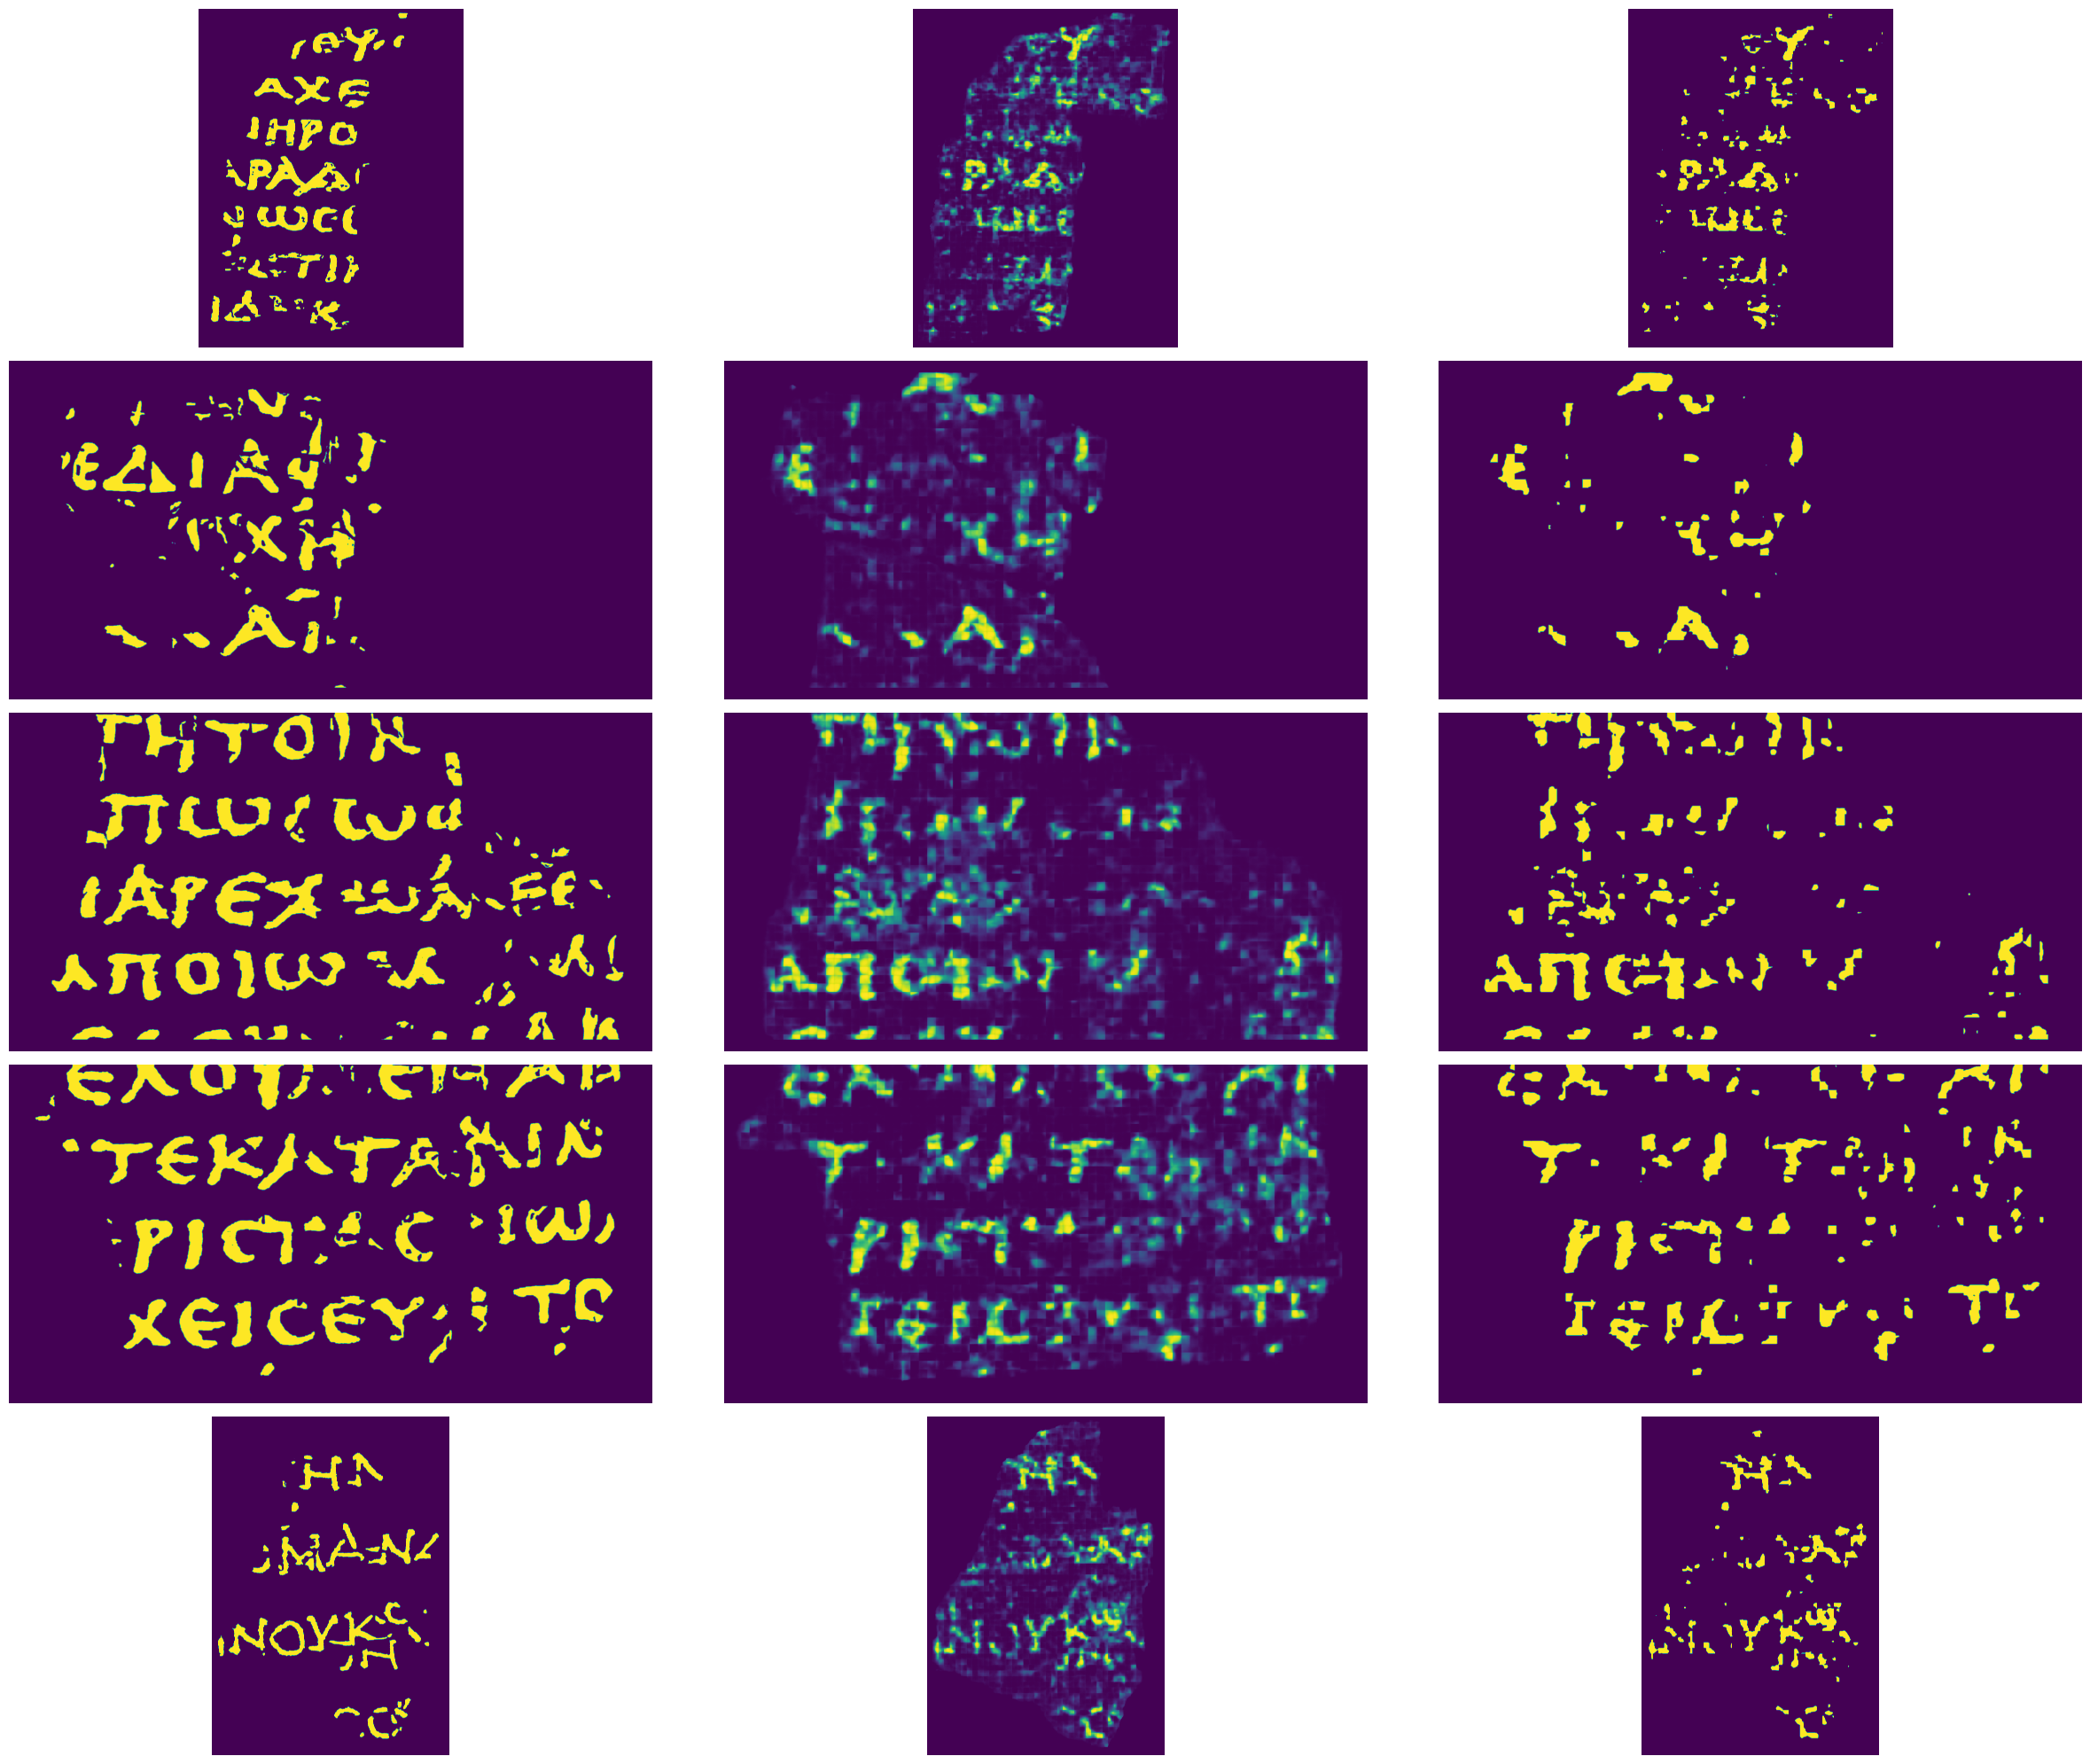

In [10]:
plot_inference(valid_label_gt_list, label_pred_list, CFG)